In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [24]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i))
    break
train_df = pd.concat(frames, sort=False)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
    break
test_df = pd.concat(frames, sort=False)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i))
    break
val_df = pd.concat(frames, sort=False)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

min_price = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
max_price = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())
#min_long = min(train_df['longitude'].min(), test_df['longitude'].min(), val_df['longitude'].min())
#max_long = max(train_df['longitude'].max(), test_df['longitude'].max(), val_df['longitude'].max())
min_lat = min(train_df['latitude'].min(), test_df['latitude'].min(), val_df['latitude'].min())
max_lat = max(train_df['latitude'].max(), test_df['latitude'].max(), val_df['latitude'].max())

train_df['price'] = (train_df['price'] - min_price)/(max_price - min_price)
#train_df['longitude'] = (train_df['longitude'] - min_long)/(max_long - min_long)
train_df['latitude'] = (train_df['latitude'] - min_lat)/(max_lat - min_lat)
train_df = train_df.reset_index(drop=True)

test_df['price'] = (test_df['price'] - min_price)/(max_price - min_price)
#test_df['longitude'] = (test_df['longitude'] - min_long)/(max_long - min_long)
test_df['latitude'] = (test_df['latitude'] - min_lat)/(max_lat - min_lat)
test_df = test_df.reset_index(drop=True)

val_df['price'] = (val_df['price'] - min_price)/(max_price - min_price)
#val_df['longitude'] = (val_df['longitude'] - min_long)/(max_long - min_long)
val_df['latitude'] = (val_df['latitude'] - min_lat)/(max_lat - min_lat)
val_df = val_df.reset_index(drop=True)
#train_df = train_df.drop(columns=["minimum_nights", "maximum_nights"])
#test_df = test_df.drop(columns=["minimum_nights", "maximum_nights"])
#val_df = val_df.drop(columns=["minimum_nights", "maximum_nights"])

#print(minimum, maximum)
bounds = [min_price, max_price]

In [14]:
train_df.head(5)

,latitude,accommodates,bathrooms,bedrooms,beds,price,amenities_TV,amenities_Air conditioning,amenities_Kitchen,amenities_Indoor fireplace,...,property_type_House,property_type_Loft,property_type_Serviced apartment,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_strict_14_with_grace_period
0,0.295877,2,1.0,0.0,2.0,0.047923,1,1,1,0,...,0,1,0,1,0,0,1,0,1,0
1,0.308621,2,1.0,1.0,2.0,0.348243,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
2,0.441983,3,1.0,1.0,2.0,0.303514,1,1,1,1,...,0,0,0,1,0,0,1,0,1,0
3,0.730529,2,1.0,1.0,1.0,0.204473,1,1,1,0,...,1,0,0,1,0,0,0,1,1,0
4,0.268638,4,1.5,1.0,1.0,0.316294,1,1,1,0,...,0,0,0,1,0,0,1,0,0,0


In [25]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [26]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=100, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=False, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=100, shuffle=False, num_workers=0)

In [27]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(66, 132)
        self.layer2 = nn.Linear(132, 264)
        self.layer3 = nn.Linear(264, 66)
        self.layer4 = nn.Linear(66, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        out = torch.relu(self.layer4(x))
        return out

In [32]:
def train(net, train_loader, val_loader, bounds, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum = 0.9)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            #print(label, output)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30], bounds)
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr,
                    'm' : m
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr,
        'm' : m
    }, folder+"/final/checkpoint_final.tar")
    

def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    #plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        #plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()
    
    
    return None

In [30]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

In [9]:
net = airbnb_net()

Starting Training...
[EPOCH 1] loss: 0.072262  time: 0.331
[EPOCH 2] loss: 0.044790  time: 0.433
[EPOCH 3] loss: 0.023271  time: 0.356
[EPOCH 4] loss: 0.035128  time: 0.344
[EPOCH 5] loss: 0.049624  time: 0.371
[EPOCH 6] loss: 0.037115  time: 0.418
[EPOCH 7] loss: 0.022272  time: 0.379
[EPOCH 8] loss: 0.024315  time: 0.398
[EPOCH 9] loss: 0.032713  time: 0.353
[EPOCH 10] loss: 0.034052  time: 1.079


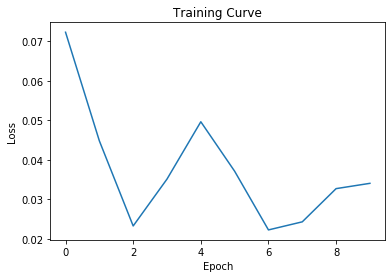

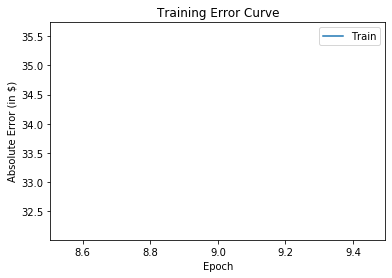

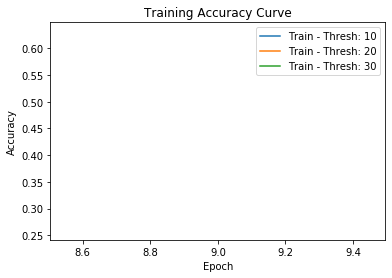

[EPOCH 11] loss: 0.026555  time: 0.387
[EPOCH 12] loss: 0.018611  time: 0.340
[EPOCH 13] loss: 0.018872  time: 0.474
[EPOCH 14] loss: 0.024552  time: 0.426
[EPOCH 15] loss: 0.024358  time: 0.393
[EPOCH 16] loss: 0.017681  time: 0.392
[EPOCH 17] loss: 0.014442  time: 0.354
[EPOCH 18] loss: 0.017058  time: 0.353
[EPOCH 19] loss: 0.019062  time: 0.388
[EPOCH 20] loss: 0.016273  time: 1.106


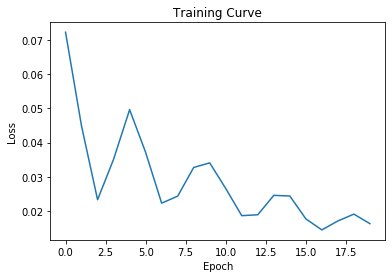

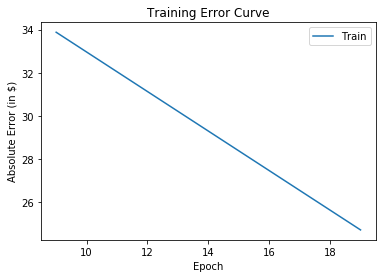

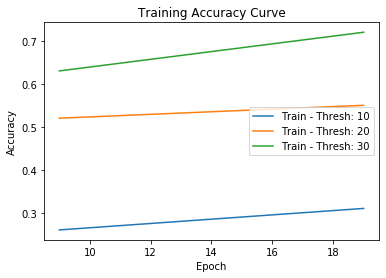

[EPOCH 21] loss: 0.012144  time: 0.326
[EPOCH 22] loss: 0.012543  time: 0.368
[EPOCH 23] loss: 0.015356  time: 0.440
[EPOCH 24] loss: 0.013790  time: 0.514
[EPOCH 25] loss: 0.010742  time: 0.396
[EPOCH 26] loss: 0.011573  time: 0.367
[EPOCH 27] loss: 0.013313  time: 0.431
[EPOCH 28] loss: 0.012164  time: 0.417
[EPOCH 29] loss: 0.010107  time: 0.377
[EPOCH 30] loss: 0.010598  time: 1.053


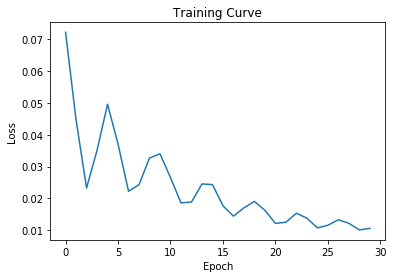

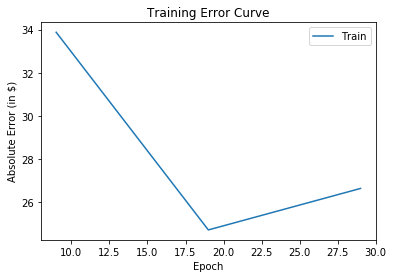

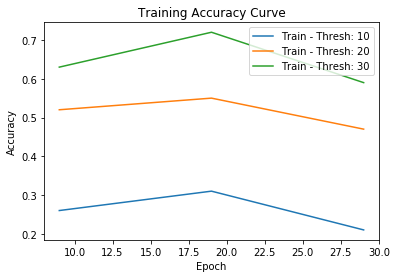

[EPOCH 31] loss: 0.011639  time: 0.405
[EPOCH 32] loss: 0.010282  time: 0.366
[EPOCH 33] loss: 0.009101  time: 0.384
[EPOCH 34] loss: 0.009681  time: 0.405
[EPOCH 35] loss: 0.009952  time: 0.624
[EPOCH 36] loss: 0.008942  time: 0.614
[EPOCH 37] loss: 0.008239  time: 0.683
[EPOCH 38] loss: 0.008685  time: 0.587
[EPOCH 39] loss: 0.008764  time: 0.317
[EPOCH 40] loss: 0.007985  time: 1.156


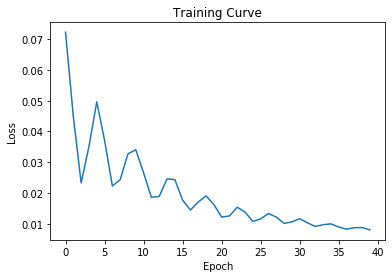

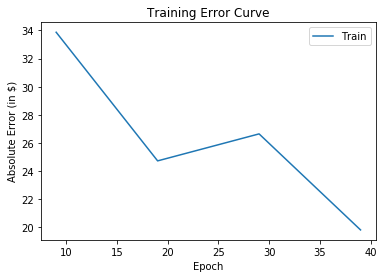

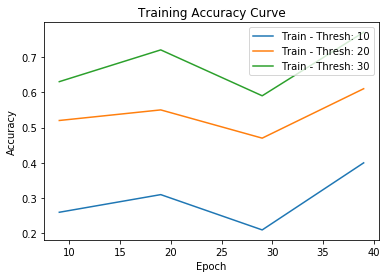

[EPOCH 41] loss: 0.007677  time: 0.374
[EPOCH 42] loss: 0.007974  time: 0.403
[EPOCH 43] loss: 0.007862  time: 0.372
[EPOCH 44] loss: 0.007276  time: 0.330
[EPOCH 45] loss: 0.007047  time: 0.280
[EPOCH 46] loss: 0.007198  time: 0.409
[EPOCH 47] loss: 0.006962  time: 0.390
[EPOCH 48] loss: 0.006500  time: 0.443
[EPOCH 49] loss: 0.006431  time: 0.425
[EPOCH 50] loss: 0.006460  time: 1.081


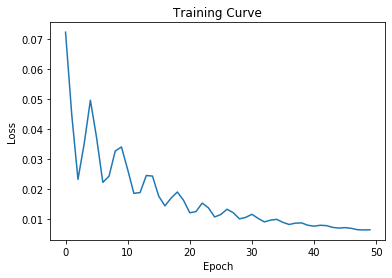

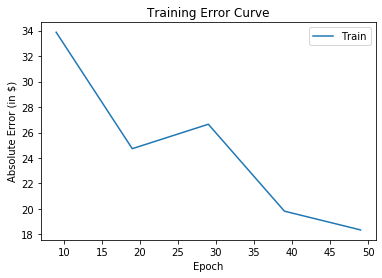

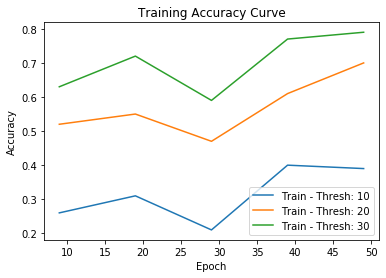

[EPOCH 51] loss: 0.006165  time: 0.314
[EPOCH 52] loss: 0.005881  time: 0.370
[EPOCH 53] loss: 0.005889  time: 0.369
[EPOCH 54] loss: 0.005791  time: 0.372
[EPOCH 55] loss: 0.005496  time: 0.361
[EPOCH 56] loss: 0.005377  time: 0.376
[EPOCH 57] loss: 0.005342  time: 0.369
[EPOCH 58] loss: 0.005130  time: 0.362
[EPOCH 59] loss: 0.004918  time: 0.431
[EPOCH 60] loss: 0.004856  time: 1.235


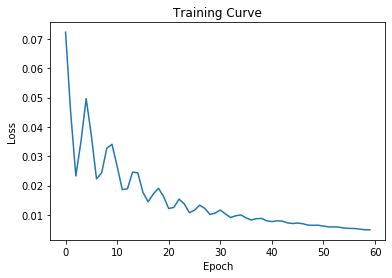

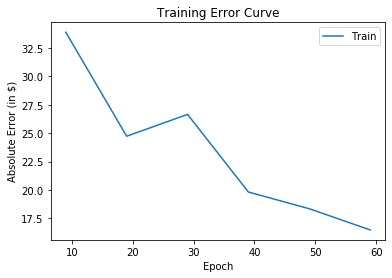

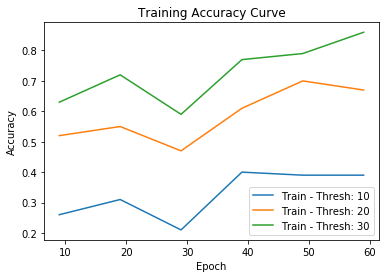

[EPOCH 61] loss: 0.004735  time: 0.336
[EPOCH 62] loss: 0.004532  time: 0.338
[EPOCH 63] loss: 0.004428  time: 0.357
[EPOCH 64] loss: 0.004354  time: 0.380
[EPOCH 65] loss: 0.004193  time: 0.407
[EPOCH 66] loss: 0.004051  time: 0.363
[EPOCH 67] loss: 0.003974  time: 0.369
[EPOCH 68] loss: 0.003848  time: 0.370
[EPOCH 69] loss: 0.003701  time: 0.354
[EPOCH 70] loss: 0.003612  time: 1.057


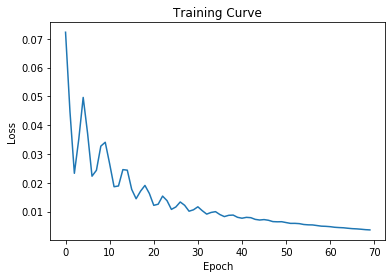

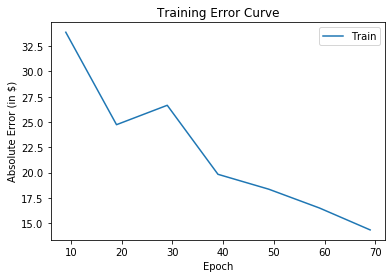

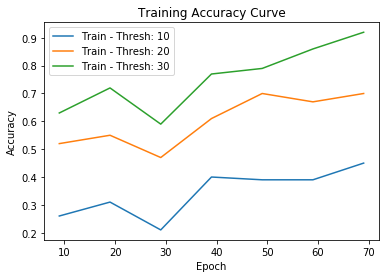

[EPOCH 71] loss: 0.003515  time: 0.287
[EPOCH 72] loss: 0.003384  time: 0.412
[EPOCH 73] loss: 0.003290  time: 0.357
[EPOCH 74] loss: 0.003210  time: 0.368
[EPOCH 75] loss: 0.003098  time: 0.365
[EPOCH 76] loss: 0.003005  time: 0.331
[EPOCH 77] loss: 0.002931  time: 0.347
[EPOCH 78] loss: 0.002835  time: 0.373
[EPOCH 79] loss: 0.002745  time: 0.367
[EPOCH 80] loss: 0.002675  time: 1.037


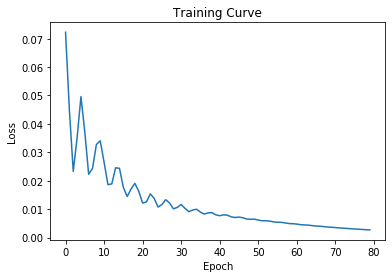

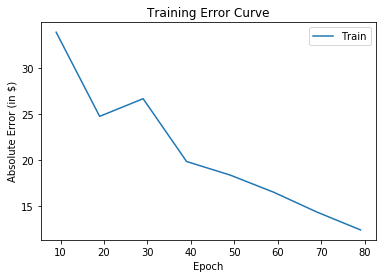

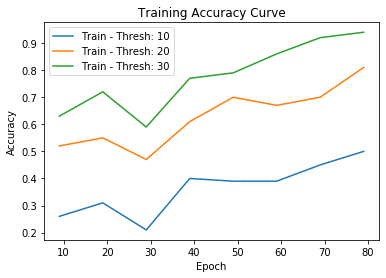

[EPOCH 81] loss: 0.002593  time: 0.330
[EPOCH 82] loss: 0.002511  time: 0.354
[EPOCH 83] loss: 0.002446  time: 0.427
[EPOCH 84] loss: 0.002373  time: 0.429
[EPOCH 85] loss: 0.002298  time: 0.504
[EPOCH 86] loss: 0.002236  time: 0.473
[EPOCH 87] loss: 0.002168  time: 0.430
[EPOCH 88] loss: 0.002098  time: 0.415
[EPOCH 89] loss: 0.002039  time: 0.406
[EPOCH 90] loss: 0.001976  time: 1.006


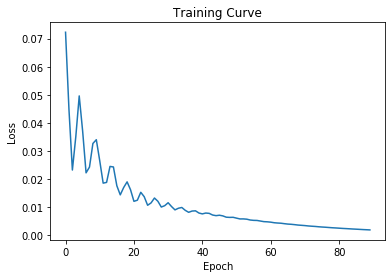

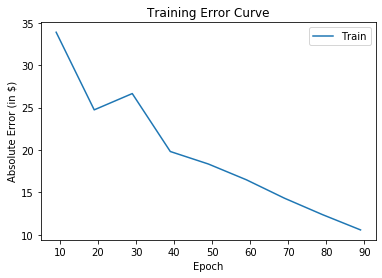

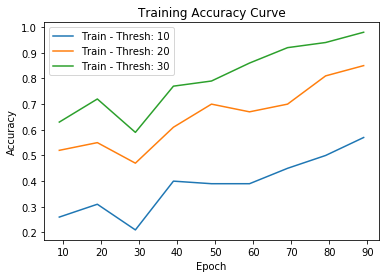

[EPOCH 91] loss: 0.001913  time: 0.245
[EPOCH 92] loss: 0.001858  time: 0.366
[EPOCH 93] loss: 0.001801  time: 0.378
[EPOCH 94] loss: 0.001743  time: 0.369
[EPOCH 95] loss: 0.001692  time: 0.337
[EPOCH 96] loss: 0.001639  time: 0.390
[EPOCH 97] loss: 0.001587  time: 0.376
[EPOCH 98] loss: 0.001539  time: 0.369
[EPOCH 99] loss: 0.001490  time: 0.425
[EPOCH 100] loss: 0.001444  time: 1.741


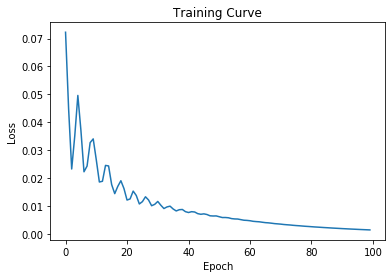

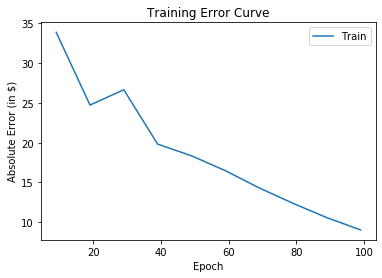

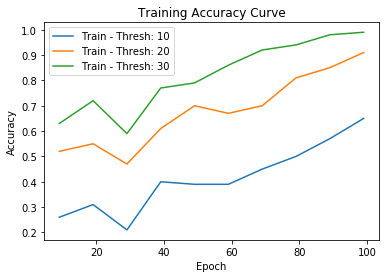

[EPOCH 101] loss: 0.001400  time: 0.400
[EPOCH 102] loss: 0.001354  time: 0.538
[EPOCH 103] loss: 0.001312  time: 0.349
[EPOCH 104] loss: 0.001271  time: 0.375
[EPOCH 105] loss: 0.001230  time: 0.402
[EPOCH 106] loss: 0.001191  time: 0.430
[EPOCH 107] loss: 0.001153  time: 0.430
[EPOCH 108] loss: 0.001116  time: 0.468
[EPOCH 109] loss: 0.001081  time: 0.474
[EPOCH 110] loss: 0.001046  time: 1.388


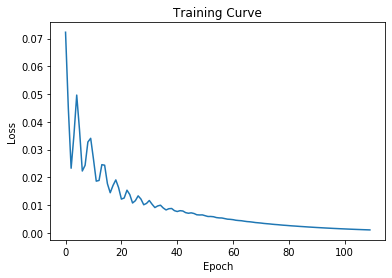

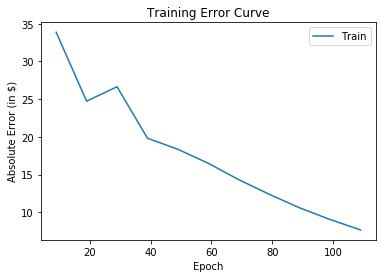

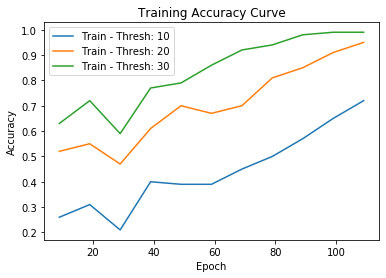

[EPOCH 111] loss: 0.001013  time: 0.347
[EPOCH 112] loss: 0.000981  time: 0.366
[EPOCH 113] loss: 0.000950  time: 0.362
[EPOCH 114] loss: 0.000920  time: 0.414
[EPOCH 115] loss: 0.000891  time: 0.386
[EPOCH 116] loss: 0.000863  time: 0.525
[EPOCH 117] loss: 0.000837  time: 0.393
[EPOCH 118] loss: 0.000811  time: 0.413
[EPOCH 119] loss: 0.000786  time: 0.365
[EPOCH 120] loss: 0.000762  time: 1.074


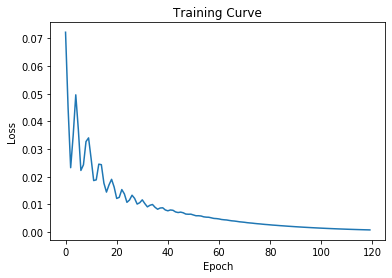

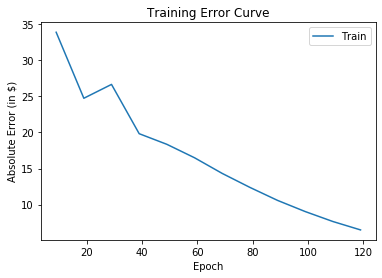

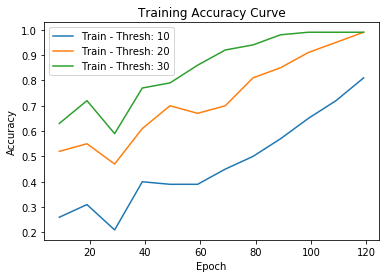

[EPOCH 121] loss: 0.000738  time: 0.329
[EPOCH 122] loss: 0.000715  time: 0.408
[EPOCH 123] loss: 0.000693  time: 0.383
[EPOCH 124] loss: 0.000672  time: 0.364
[EPOCH 125] loss: 0.000651  time: 0.396
[EPOCH 126] loss: 0.000631  time: 0.376
[EPOCH 127] loss: 0.000612  time: 0.358
[EPOCH 128] loss: 0.000594  time: 0.360
[EPOCH 129] loss: 0.000576  time: 0.363
[EPOCH 130] loss: 0.000558  time: 1.050


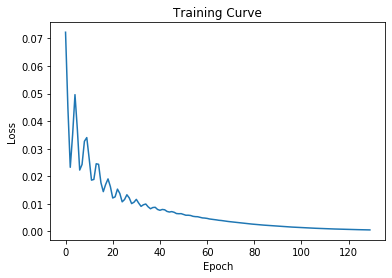

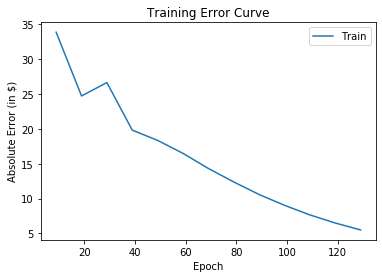

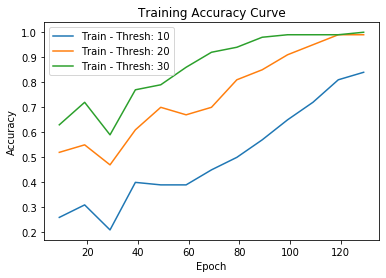

[EPOCH 131] loss: 0.000542  time: 0.340
[EPOCH 132] loss: 0.000525  time: 0.335
[EPOCH 133] loss: 0.000510  time: 0.436
[EPOCH 134] loss: 0.000495  time: 0.390
[EPOCH 135] loss: 0.000480  time: 0.356
[EPOCH 136] loss: 0.000466  time: 0.390
[EPOCH 137] loss: 0.000452  time: 0.587
[EPOCH 138] loss: 0.000439  time: 0.337
[EPOCH 139] loss: 0.000427  time: 0.377
[EPOCH 140] loss: 0.000415  time: 1.034


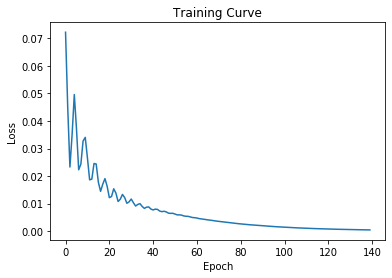

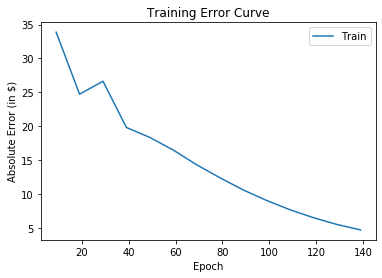

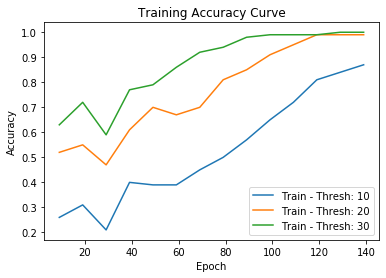

[EPOCH 141] loss: 0.000403  time: 0.271
[EPOCH 142] loss: 0.000391  time: 0.380
[EPOCH 143] loss: 0.000380  time: 0.338
[EPOCH 144] loss: 0.000369  time: 0.347
[EPOCH 145] loss: 0.000359  time: 0.312
[EPOCH 146] loss: 0.000348  time: 0.344
[EPOCH 147] loss: 0.000338  time: 0.335
[EPOCH 148] loss: 0.000329  time: 0.352
[EPOCH 149] loss: 0.000320  time: 0.374
[EPOCH 150] loss: 0.000311  time: 1.068


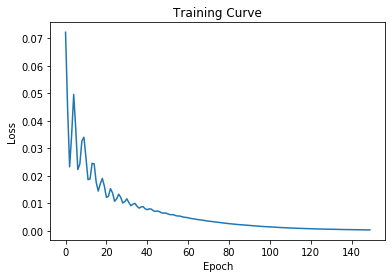

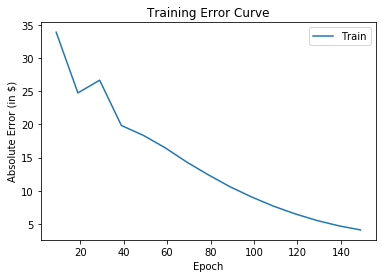

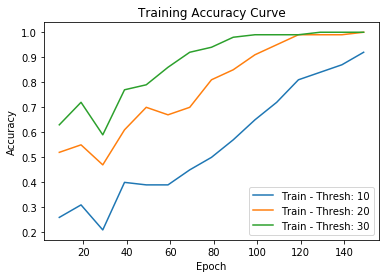

[EPOCH 151] loss: 0.000302  time: 0.282
[EPOCH 152] loss: 0.000294  time: 0.557
[EPOCH 153] loss: 0.000286  time: 0.464
[EPOCH 154] loss: 0.000278  time: 0.455
[EPOCH 155] loss: 0.000270  time: 0.555
[EPOCH 156] loss: 0.000263  time: 0.450
[EPOCH 157] loss: 0.000256  time: 0.350
[EPOCH 158] loss: 0.000249  time: 0.448
[EPOCH 159] loss: 0.000242  time: 0.572
[EPOCH 160] loss: 0.000235  time: 1.220


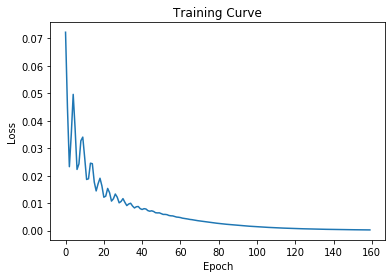

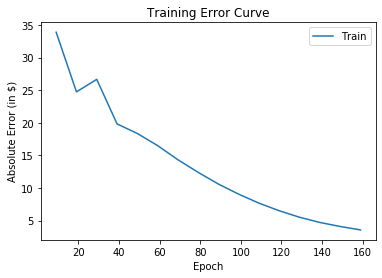

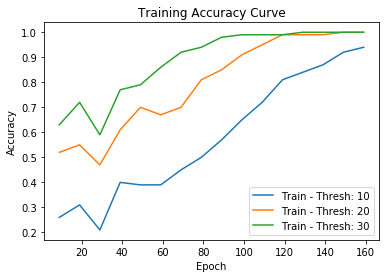

[EPOCH 161] loss: 0.000229  time: 0.310
[EPOCH 162] loss: 0.000223  time: 0.361
[EPOCH 163] loss: 0.000217  time: 0.335
[EPOCH 164] loss: 0.000211  time: 0.505
[EPOCH 165] loss: 0.000206  time: 0.518
[EPOCH 166] loss: 0.000201  time: 0.582
[EPOCH 167] loss: 0.000195  time: 0.551
[EPOCH 168] loss: 0.000190  time: 0.536
[EPOCH 169] loss: 0.000185  time: 0.537
[EPOCH 170] loss: 0.000181  time: 1.392


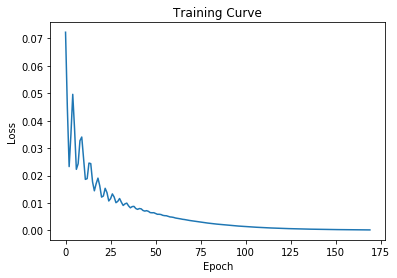

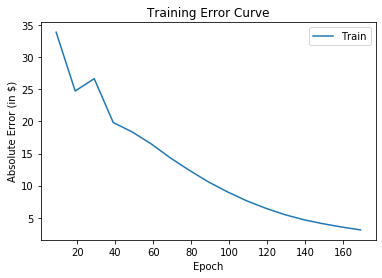

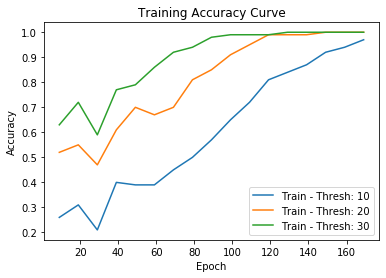

[EPOCH 171] loss: 0.000176  time: 0.322
[EPOCH 172] loss: 0.000172  time: 0.408
[EPOCH 173] loss: 0.000167  time: 0.362
[EPOCH 174] loss: 0.000163  time: 0.345
[EPOCH 175] loss: 0.000159  time: 0.381
[EPOCH 176] loss: 0.000155  time: 0.363
[EPOCH 177] loss: 0.000151  time: 0.390
[EPOCH 178] loss: 0.000148  time: 0.377
[EPOCH 179] loss: 0.000144  time: 0.345
[EPOCH 180] loss: 0.000141  time: 1.017


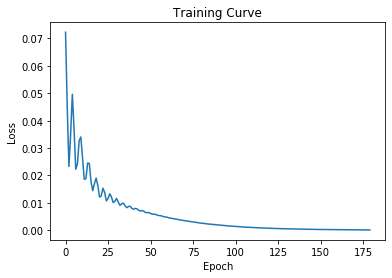

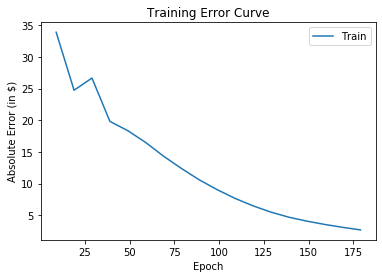

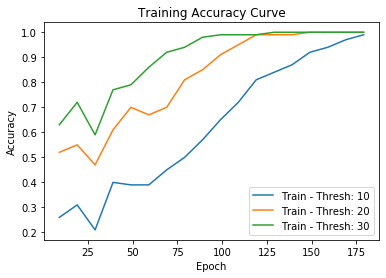

[EPOCH 181] loss: 0.000137  time: 0.284
[EPOCH 182] loss: 0.000134  time: 0.336
[EPOCH 183] loss: 0.000131  time: 0.366
[EPOCH 184] loss: 0.000128  time: 0.337
[EPOCH 185] loss: 0.000125  time: 0.363
[EPOCH 186] loss: 0.000122  time: 0.323
[EPOCH 187] loss: 0.000119  time: 0.360
[EPOCH 188] loss: 0.000116  time: 0.331
[EPOCH 189] loss: 0.000114  time: 0.352
[EPOCH 190] loss: 0.000111  time: 1.019


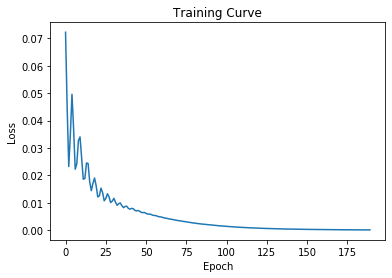

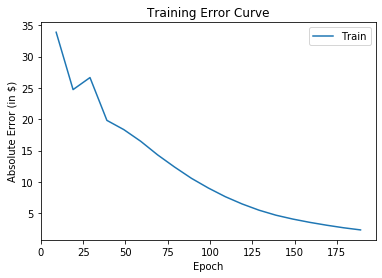

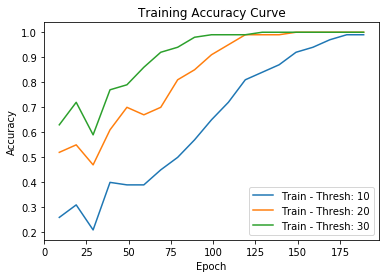

[EPOCH 191] loss: 0.000108  time: 0.298
[EPOCH 192] loss: 0.000106  time: 0.367
[EPOCH 193] loss: 0.000104  time: 0.364
[EPOCH 194] loss: 0.000101  time: 0.368
[EPOCH 195] loss: 0.000099  time: 0.336
[EPOCH 196] loss: 0.000097  time: 0.381
[EPOCH 197] loss: 0.000095  time: 0.325
[EPOCH 198] loss: 0.000093  time: 0.343
[EPOCH 199] loss: 0.000091  time: 0.427
[EPOCH 200] loss: 0.000089  time: 1.030


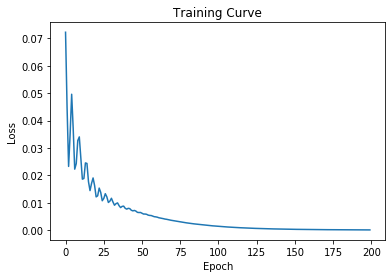

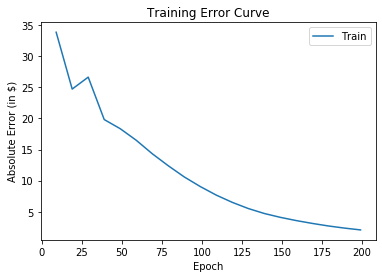

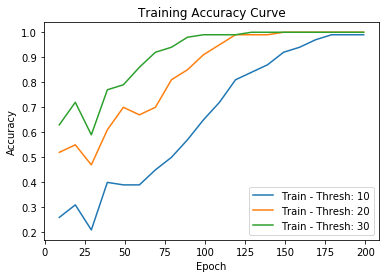

[EPOCH 201] loss: 0.000087  time: 0.280
[EPOCH 202] loss: 0.000085  time: 0.335
[EPOCH 203] loss: 0.000083  time: 0.398
[EPOCH 204] loss: 0.000081  time: 0.386
[EPOCH 205] loss: 0.000080  time: 0.508
[EPOCH 206] loss: 0.000078  time: 0.344
[EPOCH 207] loss: 0.000076  time: 0.290
[EPOCH 208] loss: 0.000075  time: 0.519
[EPOCH 209] loss: 0.000073  time: 0.229
[EPOCH 210] loss: 0.000072  time: 0.913


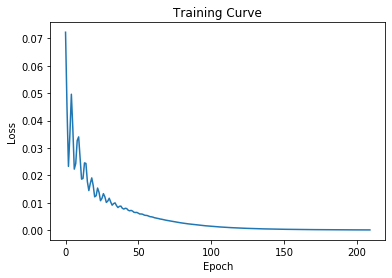

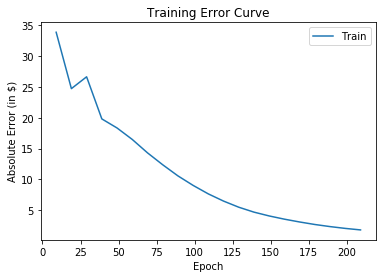

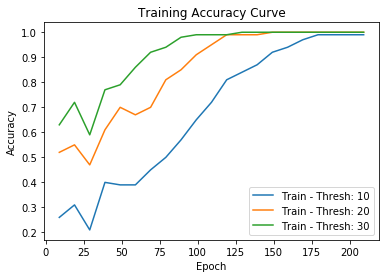

[EPOCH 211] loss: 0.000070  time: 0.275
[EPOCH 212] loss: 0.000069  time: 0.368
[EPOCH 213] loss: 0.000067  time: 0.327
[EPOCH 214] loss: 0.000066  time: 0.601
[EPOCH 215] loss: 0.000065  time: 0.339
[EPOCH 216] loss: 0.000063  time: 0.423
[EPOCH 217] loss: 0.000062  time: 0.588
[EPOCH 218] loss: 0.000061  time: 0.443
[EPOCH 219] loss: 0.000060  time: 0.449
[EPOCH 220] loss: 0.000058  time: 1.666


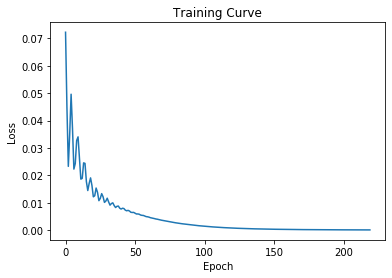

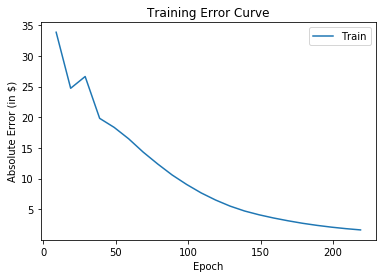

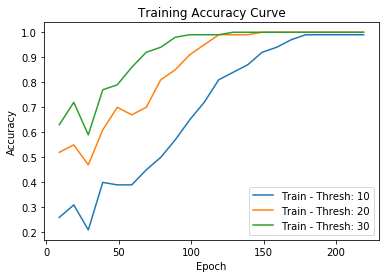

[EPOCH 221] loss: 0.000057  time: 0.566
[EPOCH 222] loss: 0.000056  time: 0.613
[EPOCH 223] loss: 0.000055  time: 0.927
[EPOCH 224] loss: 0.000054  time: 0.556
[EPOCH 225] loss: 0.000053  time: 0.444
[EPOCH 226] loss: 0.000052  time: 0.528
[EPOCH 227] loss: 0.000051  time: 0.589
[EPOCH 228] loss: 0.000050  time: 0.464
[EPOCH 229] loss: 0.000049  time: 0.621
[EPOCH 230] loss: 0.000048  time: 1.038


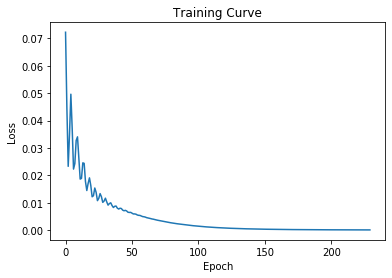

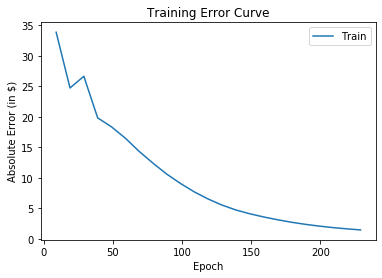

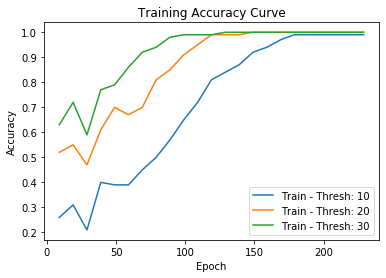

[EPOCH 231] loss: 0.000047  time: 0.282
[EPOCH 232] loss: 0.000046  time: 0.348
[EPOCH 233] loss: 0.000045  time: 0.379
[EPOCH 234] loss: 0.000045  time: 0.358
[EPOCH 235] loss: 0.000044  time: 0.422
[EPOCH 236] loss: 0.000043  time: 0.366
[EPOCH 237] loss: 0.000042  time: 0.356
[EPOCH 238] loss: 0.000041  time: 0.377
[EPOCH 239] loss: 0.000041  time: 0.362
[EPOCH 240] loss: 0.000040  time: 1.014


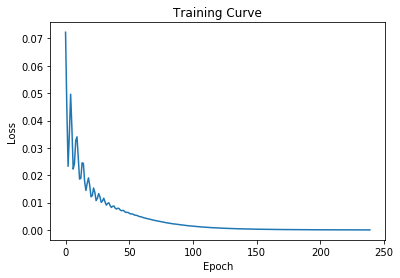

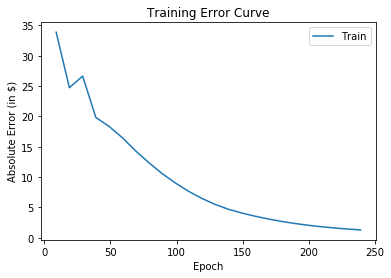

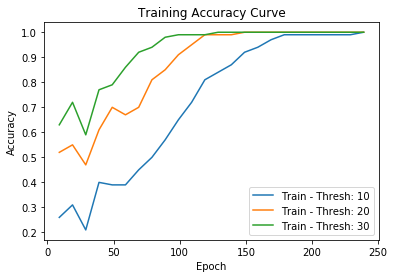

[EPOCH 241] loss: 0.000039  time: 0.263
[EPOCH 242] loss: 0.000038  time: 0.367
[EPOCH 243] loss: 0.000038  time: 0.391
[EPOCH 244] loss: 0.000037  time: 0.353
[EPOCH 245] loss: 0.000036  time: 0.415
[EPOCH 246] loss: 0.000036  time: 0.367
[EPOCH 247] loss: 0.000035  time: 0.422
[EPOCH 248] loss: 0.000034  time: 0.381
[EPOCH 249] loss: 0.000034  time: 0.347
[EPOCH 250] loss: 0.000033  time: 0.993


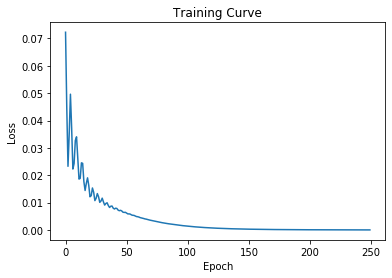

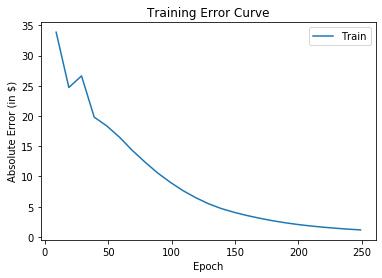

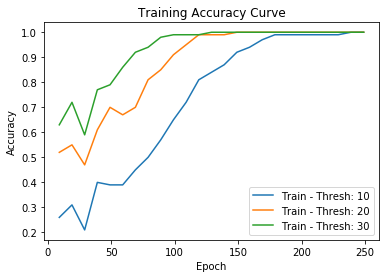

Training Completed...
[FINAL] loss: 0.000033  time: 170.262


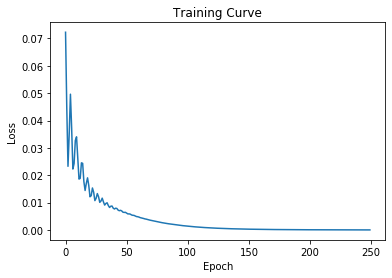

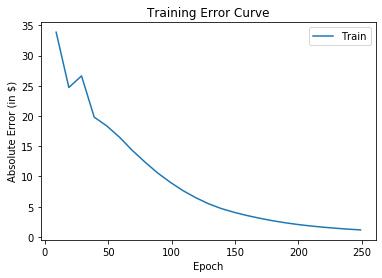

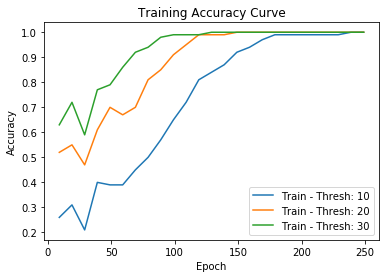

In [22]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Aditi/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

#train(net, train_loader, val_loader, [minimum, maximum], rootdir)

train(net, train_loader, val_loader, [min_price, max_price], rootdir, lr = 0.1, num_epoch = 250)

Starting Training...
---[ITER 10] loss: 0.108869  time: 3.590
---[ITER 20] loss: 0.129425  time: 3.475
---[ITER 30] loss: 0.117821  time: 3.655
---[ITER 40] loss: 0.126482  time: 3.637
---[ITER 50] loss: 0.116497  time: 3.436
---[ITER 60] loss: 0.119127  time: 3.573
---[ITER 70] loss: 0.120189  time: 3.519
---[ITER 80] loss: 0.112695  time: 3.659
---[ITER 90] loss: 0.123467  time: 3.367
---[ITER 100] loss: 0.112604  time: 3.544
[EPOCH 1] loss: 0.118718  time: 35.468
---[ITER 10] loss: 0.108869  time: 3.453
---[ITER 20] loss: 0.129425  time: 3.422
---[ITER 30] loss: 0.117821  time: 3.694
---[ITER 40] loss: 0.126482  time: 3.623
---[ITER 50] loss: 0.116497  time: 3.545
---[ITER 60] loss: 0.119127  time: 3.459
---[ITER 70] loss: 0.120189  time: 3.740
---[ITER 80] loss: 0.112695  time: 3.726
---[ITER 90] loss: 0.123467  time: 4.059
---[ITER 100] loss: 0.112604  time: 3.674
[EPOCH 2] loss: 0.118718  time: 36.410
---[ITER 10] loss: 0.108869  time: 3.904
---[ITER 20] loss: 0.129425  time: 3.8

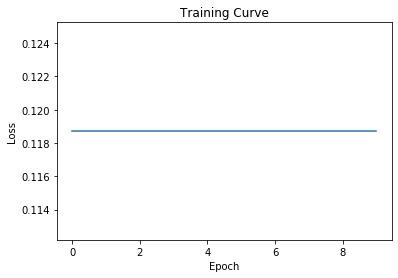

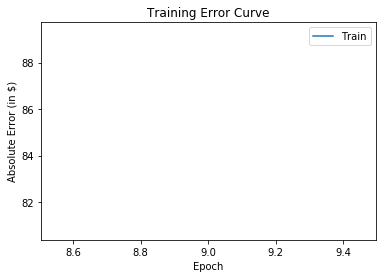

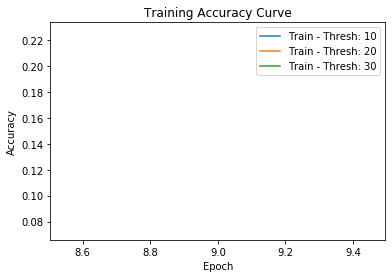

---[ITER 10] loss: 0.108869  time: 4.025
---[ITER 20] loss: 0.129425  time: 3.419
---[ITER 30] loss: 0.117821  time: 3.567
---[ITER 40] loss: 0.126482  time: 3.763
---[ITER 50] loss: 0.116497  time: 3.646
---[ITER 60] loss: 0.119127  time: 3.684
---[ITER 70] loss: 0.120189  time: 3.573
---[ITER 80] loss: 0.112695  time: 4.739
---[ITER 90] loss: 0.123467  time: 4.874
---[ITER 100] loss: 0.112604  time: 3.359
[EPOCH 11] loss: 0.118718  time: 38.663
---[ITER 10] loss: 0.108869  time: 3.449
---[ITER 20] loss: 0.129425  time: 3.569
---[ITER 30] loss: 0.117821  time: 3.442
---[ITER 40] loss: 0.126482  time: 3.537
---[ITER 50] loss: 0.116497  time: 3.414
---[ITER 60] loss: 0.119127  time: 3.387
---[ITER 70] loss: 0.120189  time: 3.624
---[ITER 80] loss: 0.112695  time: 3.688
---[ITER 90] loss: 0.123467  time: 3.286
---[ITER 100] loss: 0.112604  time: 3.322
[EPOCH 12] loss: 0.118718  time: 34.733
---[ITER 10] loss: 0.108869  time: 3.383
---[ITER 20] loss: 0.129425  time: 3.438
---[ITER 30] los

In [ ]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Aditi/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

#train(net, train_loader, val_loader, [minimum, maximum], rootdir)

train(net, train_loader, val_loader, [min_price, max_price], rootdir, lr = 0.1, num_epoch = 250)

In [ ]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Aditi/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

#train(net, train_loader, val_loader, [minimum, maximum], rootdir)

train(net, train_loader, val_loader, [min_price, max_price], rootdir, lr = 0.01, num_epoch = 250)

In [43]:
print(get_error(net, train_loader, val_loader, [10, 20, 30], [min_price, max_price]))

(49.69295288085937, [0.08, 0.17, 0.26], 60.44763545989991, [0.07, 0.13, 0.21])


Starting Training...
[EPOCH 1] loss: 0.061042  time: 0.150
[EPOCH 2] loss: 0.044400  time: 0.230
[EPOCH 3] loss: 0.030131  time: 0.202
[EPOCH 4] loss: 0.031242  time: 0.250
[EPOCH 5] loss: 0.041700  time: 0.277
[EPOCH 6] loss: 0.046004  time: 0.234
[EPOCH 7] loss: 0.038664  time: 0.240
[EPOCH 8] loss: 0.028911  time: 0.236
[EPOCH 9] loss: 0.026446  time: 0.255
[EPOCH 10] loss: 0.030632  time: 0.590


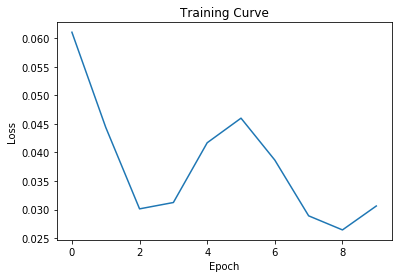

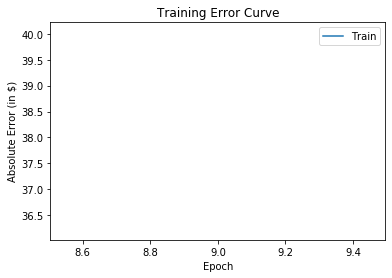

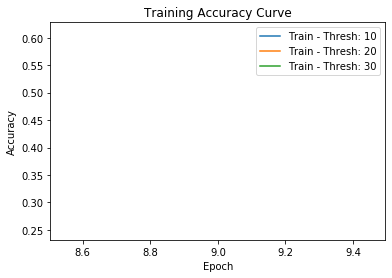

[EPOCH 11] loss: 0.034185  time: 0.118
[EPOCH 12] loss: 0.032000  time: 0.188
[EPOCH 13] loss: 0.026033  time: 0.216
[EPOCH 14] loss: 0.022481  time: 0.231
[EPOCH 15] loss: 0.024327  time: 0.216
[EPOCH 16] loss: 0.027385  time: 0.225
[EPOCH 17] loss: 0.026131  time: 0.220
[EPOCH 18] loss: 0.021680  time: 0.233
[EPOCH 19] loss: 0.019399  time: 0.228
[EPOCH 20] loss: 0.020676  time: 0.533


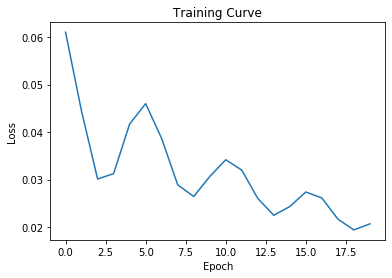

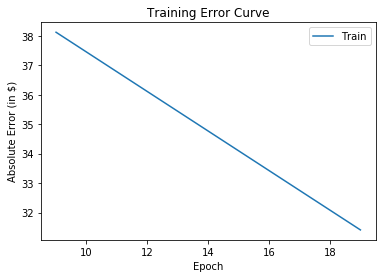

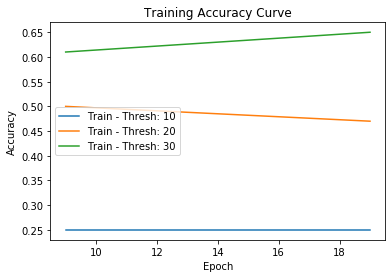

[EPOCH 21] loss: 0.021774  time: 0.162
[EPOCH 22] loss: 0.019755  time: 0.217
[EPOCH 23] loss: 0.016561  time: 0.216
[EPOCH 24] loss: 0.016038  time: 0.211
[EPOCH 25] loss: 0.017545  time: 0.221
[EPOCH 26] loss: 0.016686  time: 0.221
[EPOCH 27] loss: 0.013984  time: 0.213
[EPOCH 28] loss: 0.013681  time: 0.214
[EPOCH 29] loss: 0.014870  time: 0.209
[EPOCH 30] loss: 0.013959  time: 0.590


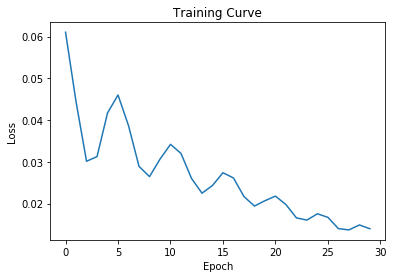

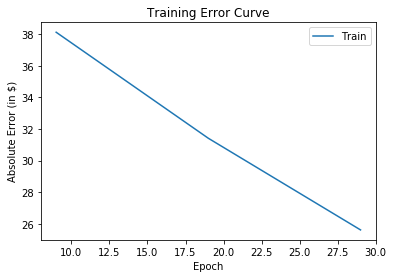

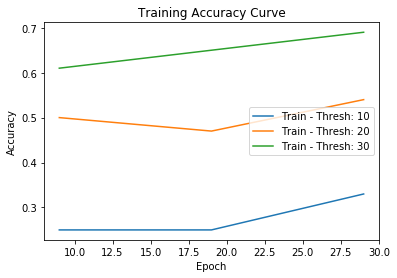

[EPOCH 31] loss: 0.012266  time: 0.132
[EPOCH 32] loss: 0.012938  time: 0.216
[EPOCH 33] loss: 0.013506  time: 0.218
[EPOCH 34] loss: 0.012016  time: 0.214
[EPOCH 35] loss: 0.011839  time: 0.225
[EPOCH 36] loss: 0.012588  time: 0.228
[EPOCH 37] loss: 0.011687  time: 0.210
[EPOCH 38] loss: 0.010870  time: 0.208
[EPOCH 39] loss: 0.011355  time: 0.220
[EPOCH 40] loss: 0.010875  time: 0.591


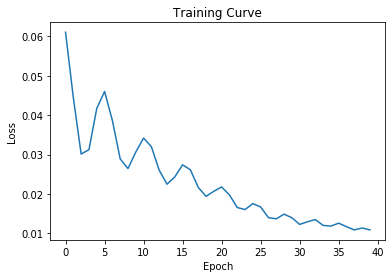

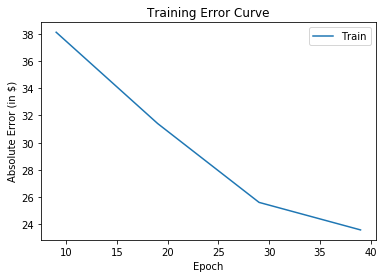

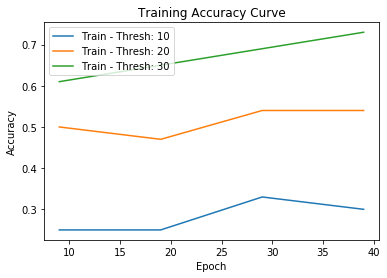

[EPOCH 41] loss: 0.010037  time: 0.135
[EPOCH 42] loss: 0.010250  time: 0.228
[EPOCH 43] loss: 0.010120  time: 0.219
[EPOCH 44] loss: 0.009429  time: 0.220
[EPOCH 45] loss: 0.009411  time: 0.213
[EPOCH 46] loss: 0.009475  time: 0.215
[EPOCH 47] loss: 0.008963  time: 0.216
[EPOCH 48] loss: 0.008793  time: 0.209
[EPOCH 49] loss: 0.008868  time: 0.220
[EPOCH 50] loss: 0.008509  time: 0.583


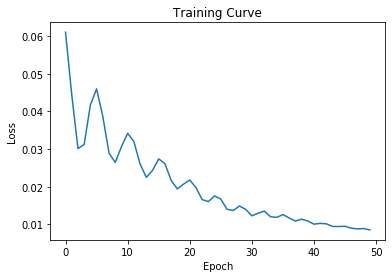

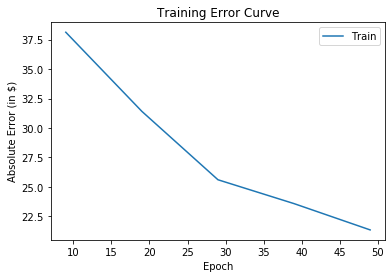

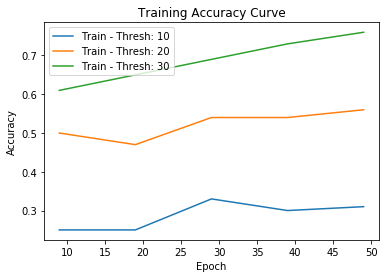

[EPOCH 51] loss: 0.008220  time: 0.139
[EPOCH 52] loss: 0.008248  time: 0.227
[EPOCH 53] loss: 0.007981  time: 0.234
[EPOCH 54] loss: 0.007669  time: 0.217
[EPOCH 55] loss: 0.007630  time: 0.217
[EPOCH 56] loss: 0.007430  time: 0.217
[EPOCH 57] loss: 0.007144  time: 0.222
[EPOCH 58] loss: 0.007079  time: 0.216
[EPOCH 59] loss: 0.006913  time: 0.208
[EPOCH 60] loss: 0.006669  time: 0.547


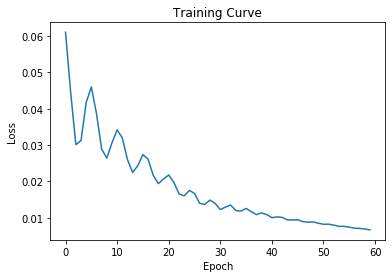

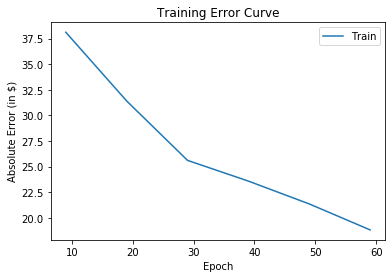

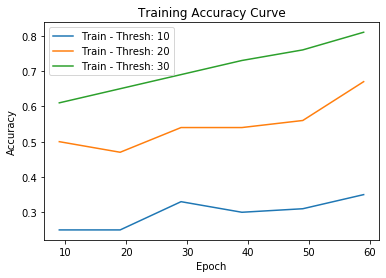

[EPOCH 61] loss: 0.006591  time: 0.116
[EPOCH 62] loss: 0.006430  time: 0.214
[EPOCH 63] loss: 0.006219  time: 0.208
[EPOCH 64] loss: 0.006132  time: 0.209
[EPOCH 65] loss: 0.005961  time: 0.216
[EPOCH 66] loss: 0.005781  time: 0.213
[EPOCH 67] loss: 0.005690  time: 0.216
[EPOCH 68] loss: 0.005516  time: 0.214
[EPOCH 69] loss: 0.005377  time: 0.215
[EPOCH 70] loss: 0.005281  time: 0.555


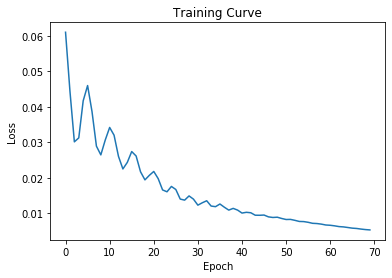

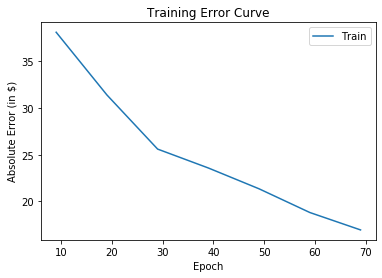

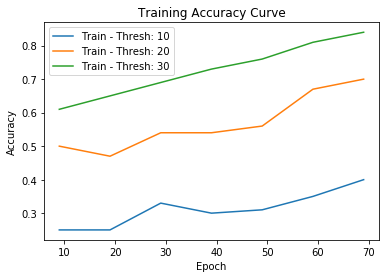

[EPOCH 71] loss: 0.005125  time: 0.152
[EPOCH 72] loss: 0.005019  time: 0.212
[EPOCH 73] loss: 0.004913  time: 0.216
[EPOCH 74] loss: 0.004772  time: 0.215
[EPOCH 75] loss: 0.004678  time: 0.220
[EPOCH 76] loss: 0.004558  time: 0.222
[EPOCH 77] loss: 0.004441  time: 0.229
[EPOCH 78] loss: 0.004350  time: 0.186
[EPOCH 79] loss: 0.004230  time: 0.241
[EPOCH 80] loss: 0.004132  time: 0.604


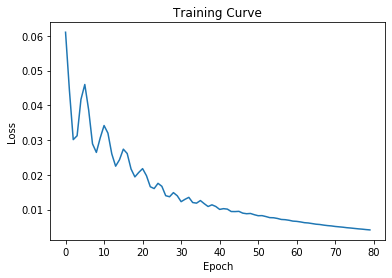

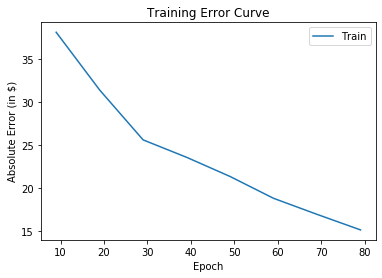

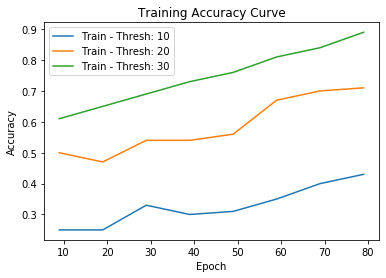

[EPOCH 81] loss: 0.004035  time: 0.120
[EPOCH 82] loss: 0.003927  time: 0.206
[EPOCH 83] loss: 0.003841  time: 0.220
[EPOCH 84] loss: 0.003741  time: 0.249
[EPOCH 85] loss: 0.003653  time: 0.231
[EPOCH 86] loss: 0.003570  time: 0.229
[EPOCH 87] loss: 0.003480  time: 0.227
[EPOCH 88] loss: 0.003405  time: 0.228
[EPOCH 89] loss: 0.003319  time: 0.224
[EPOCH 90] loss: 0.003245  time: 0.641


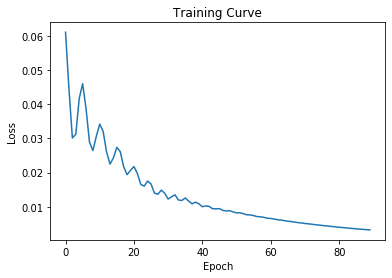

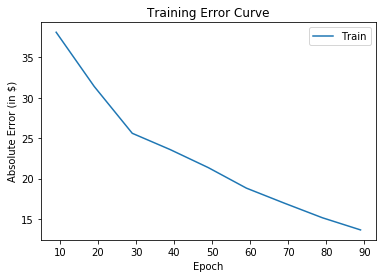

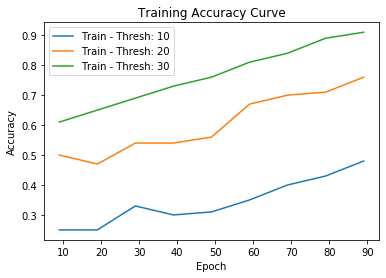

[EPOCH 91] loss: 0.003169  time: 0.123
[EPOCH 92] loss: 0.003094  time: 0.212
[EPOCH 93] loss: 0.003026  time: 0.219
[EPOCH 94] loss: 0.002952  time: 0.218
[EPOCH 95] loss: 0.002886  time: 0.203
[EPOCH 96] loss: 0.002818  time: 0.214
[EPOCH 97] loss: 0.002754  time: 0.218
[EPOCH 98] loss: 0.002693  time: 0.220
[EPOCH 99] loss: 0.002631  time: 0.218
[EPOCH 100] loss: 0.002574  time: 0.515


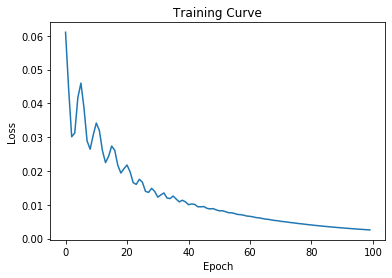

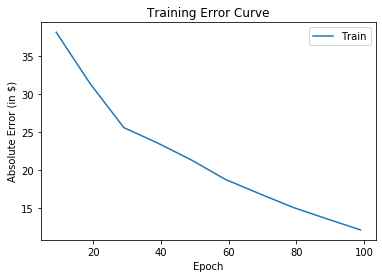

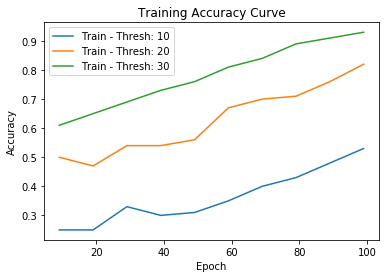

[EPOCH 101] loss: 0.002514  time: 0.116
[EPOCH 102] loss: 0.002459  time: 0.217
[EPOCH 103] loss: 0.002403  time: 0.212
[EPOCH 104] loss: 0.002349  time: 0.214
[EPOCH 105] loss: 0.002295  time: 0.215
[EPOCH 106] loss: 0.002242  time: 0.213
[EPOCH 107] loss: 0.002191  time: 0.220
[EPOCH 108] loss: 0.002139  time: 0.207
[EPOCH 109] loss: 0.002090  time: 0.215
[EPOCH 110] loss: 0.002040  time: 0.547


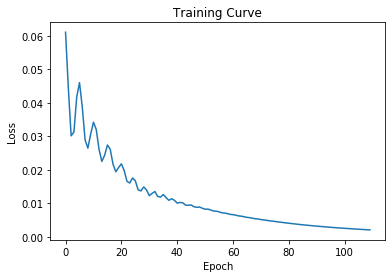

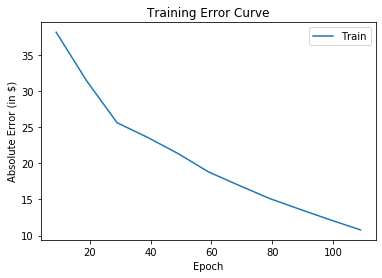

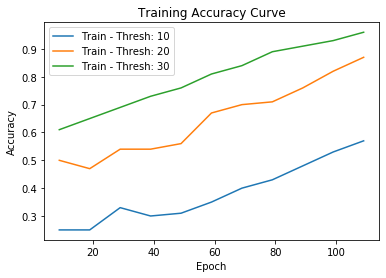

[EPOCH 111] loss: 0.001992  time: 0.104
[EPOCH 112] loss: 0.001944  time: 0.220
[EPOCH 113] loss: 0.001897  time: 0.214
[EPOCH 114] loss: 0.001850  time: 0.223
[EPOCH 115] loss: 0.001804  time: 0.211
[EPOCH 116] loss: 0.001760  time: 0.219
[EPOCH 117] loss: 0.001716  time: 0.219
[EPOCH 118] loss: 0.001673  time: 0.214
[EPOCH 119] loss: 0.001630  time: 0.211
[EPOCH 120] loss: 0.001588  time: 0.532


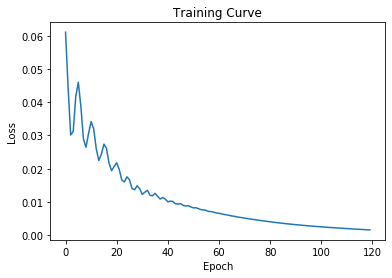

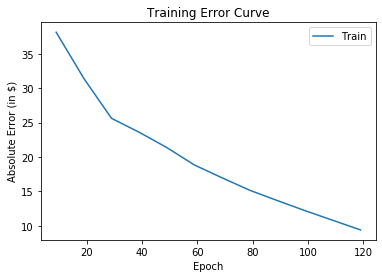

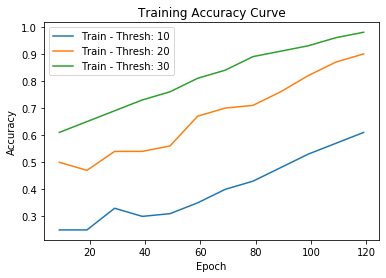

[EPOCH 121] loss: 0.001548  time: 0.116
[EPOCH 122] loss: 0.001508  time: 0.215
[EPOCH 123] loss: 0.001470  time: 0.218
[EPOCH 124] loss: 0.001433  time: 0.215
[EPOCH 125] loss: 0.001396  time: 0.212
[EPOCH 126] loss: 0.001360  time: 0.229
[EPOCH 127] loss: 0.001325  time: 0.215
[EPOCH 128] loss: 0.001290  time: 0.220
[EPOCH 129] loss: 0.001256  time: 0.216
[EPOCH 130] loss: 0.001223  time: 0.558


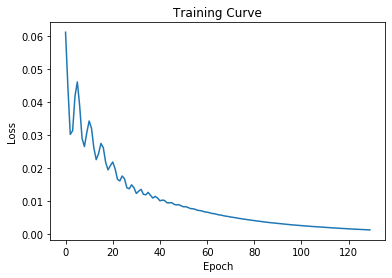

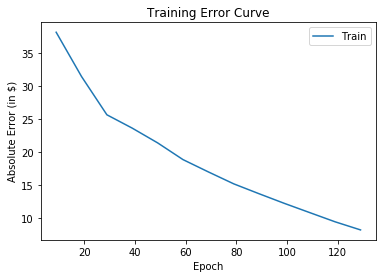

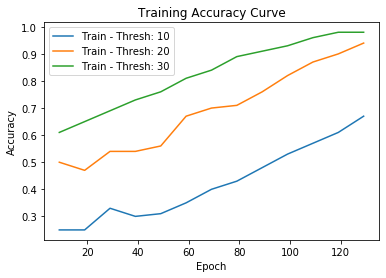

[EPOCH 131] loss: 0.001190  time: 0.131
[EPOCH 132] loss: 0.001159  time: 0.225
[EPOCH 133] loss: 0.001128  time: 0.221
[EPOCH 134] loss: 0.001098  time: 0.219
[EPOCH 135] loss: 0.001068  time: 0.245
[EPOCH 136] loss: 0.001040  time: 0.231
[EPOCH 137] loss: 0.001012  time: 0.246
[EPOCH 138] loss: 0.000985  time: 0.242
[EPOCH 139] loss: 0.000958  time: 0.222
[EPOCH 140] loss: 0.000933  time: 0.634


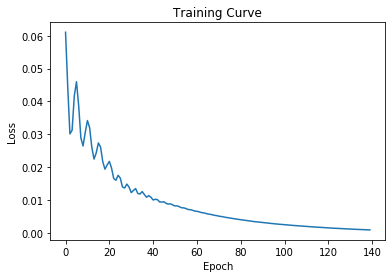

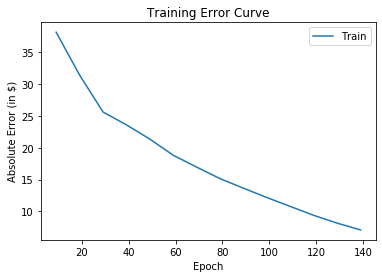

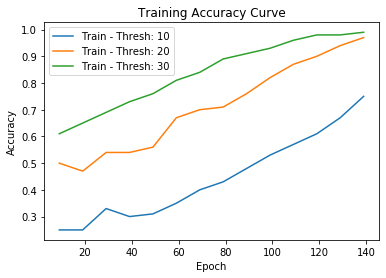

[EPOCH 141] loss: 0.000908  time: 0.126
[EPOCH 142] loss: 0.000883  time: 0.212
[EPOCH 143] loss: 0.000859  time: 0.223
[EPOCH 144] loss: 0.000836  time: 0.216
[EPOCH 145] loss: 0.000813  time: 0.217
[EPOCH 146] loss: 0.000791  time: 0.221
[EPOCH 147] loss: 0.000769  time: 0.219
[EPOCH 148] loss: 0.000748  time: 0.214
[EPOCH 149] loss: 0.000728  time: 0.216
[EPOCH 150] loss: 0.000708  time: 0.584


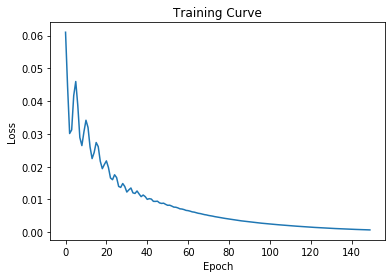

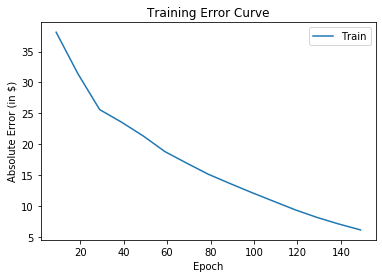

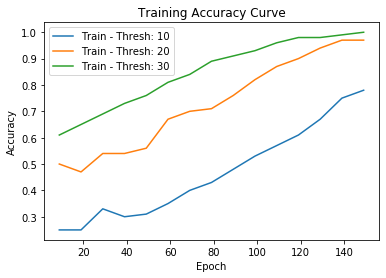

[EPOCH 151] loss: 0.000689  time: 0.108
[EPOCH 152] loss: 0.000670  time: 0.213
[EPOCH 153] loss: 0.000651  time: 0.224
[EPOCH 154] loss: 0.000633  time: 0.215
[EPOCH 155] loss: 0.000616  time: 0.207
[EPOCH 156] loss: 0.000599  time: 0.213
[EPOCH 157] loss: 0.000582  time: 0.216
[EPOCH 158] loss: 0.000566  time: 0.219
[EPOCH 159] loss: 0.000550  time: 0.184
[EPOCH 160] loss: 0.000535  time: 0.570


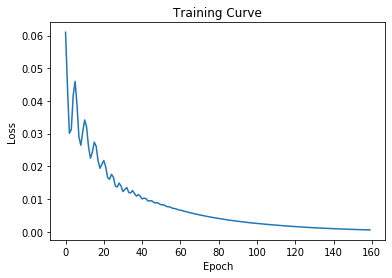

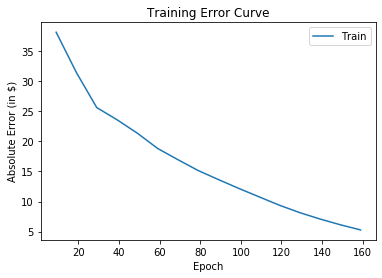

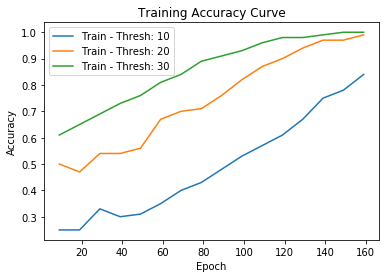

[EPOCH 161] loss: 0.000520  time: 0.104
[EPOCH 162] loss: 0.000506  time: 0.218
[EPOCH 163] loss: 0.000492  time: 0.221
[EPOCH 164] loss: 0.000479  time: 0.220
[EPOCH 165] loss: 0.000466  time: 0.212
[EPOCH 166] loss: 0.000453  time: 0.212
[EPOCH 167] loss: 0.000440  time: 0.220
[EPOCH 168] loss: 0.000428  time: 0.220
[EPOCH 169] loss: 0.000416  time: 0.204
[EPOCH 170] loss: 0.000405  time: 0.551


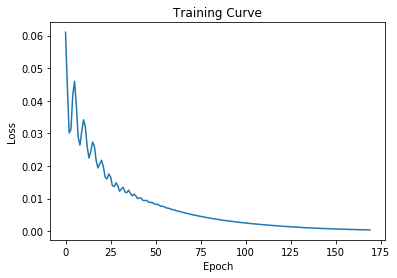

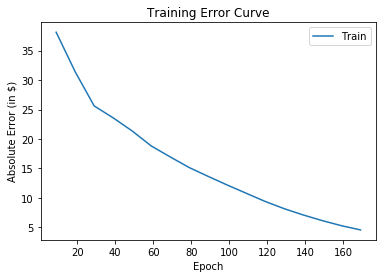

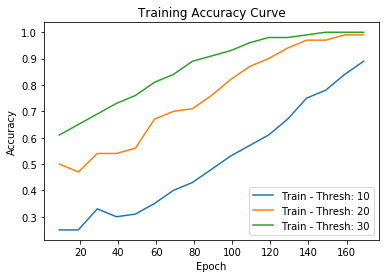

[EPOCH 171] loss: 0.000394  time: 0.125
[EPOCH 172] loss: 0.000383  time: 0.216
[EPOCH 173] loss: 0.000373  time: 0.221
[EPOCH 174] loss: 0.000362  time: 0.215
[EPOCH 175] loss: 0.000352  time: 0.209
[EPOCH 176] loss: 0.000343  time: 0.217
[EPOCH 177] loss: 0.000333  time: 0.213
[EPOCH 178] loss: 0.000324  time: 0.202
[EPOCH 179] loss: 0.000315  time: 0.214
[EPOCH 180] loss: 0.000307  time: 0.561


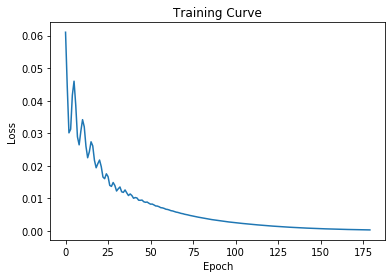

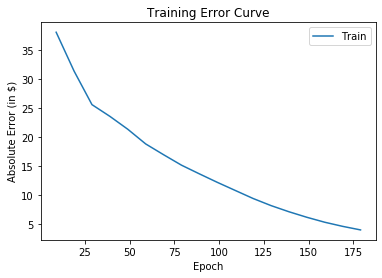

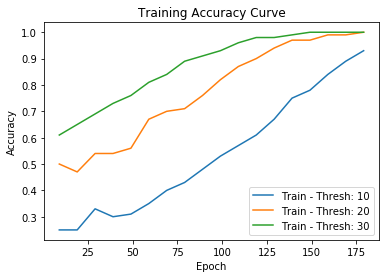

[EPOCH 181] loss: 0.000298  time: 0.118
[EPOCH 182] loss: 0.000290  time: 0.215
[EPOCH 183] loss: 0.000282  time: 0.207
[EPOCH 184] loss: 0.000275  time: 0.217
[EPOCH 185] loss: 0.000268  time: 0.244
[EPOCH 186] loss: 0.000260  time: 0.233
[EPOCH 187] loss: 0.000253  time: 0.238
[EPOCH 188] loss: 0.000247  time: 0.245
[EPOCH 189] loss: 0.000240  time: 0.227
[EPOCH 190] loss: 0.000234  time: 0.546


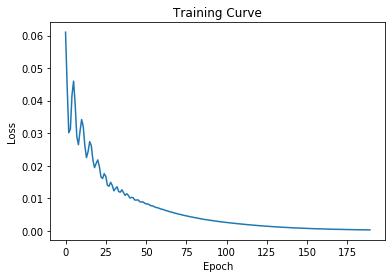

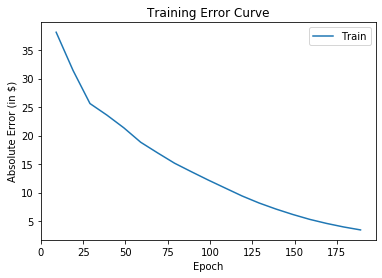

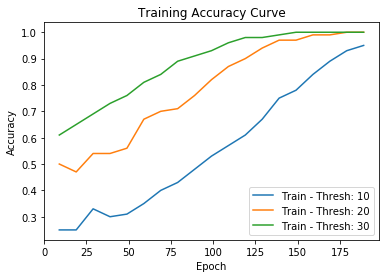

[EPOCH 191] loss: 0.000227  time: 0.108
[EPOCH 192] loss: 0.000221  time: 0.194
[EPOCH 193] loss: 0.000216  time: 0.217
[EPOCH 194] loss: 0.000210  time: 0.202
[EPOCH 195] loss: 0.000204  time: 0.216
[EPOCH 196] loss: 0.000199  time: 0.203
[EPOCH 197] loss: 0.000193  time: 0.203
[EPOCH 198] loss: 0.000188  time: 0.220
[EPOCH 199] loss: 0.000183  time: 0.213
[EPOCH 200] loss: 0.000178  time: 0.538


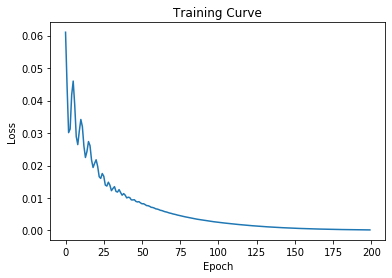

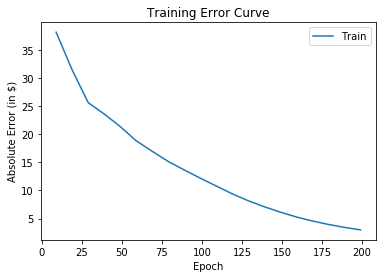

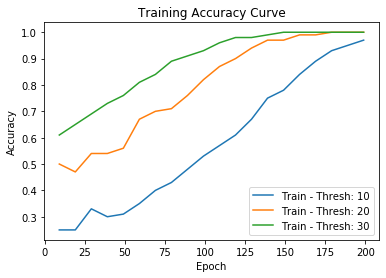

[EPOCH 201] loss: 0.000174  time: 0.108
[EPOCH 202] loss: 0.000169  time: 0.216
[EPOCH 203] loss: 0.000165  time: 0.214
[EPOCH 204] loss: 0.000160  time: 0.212
[EPOCH 205] loss: 0.000156  time: 0.217
[EPOCH 206] loss: 0.000152  time: 0.207
[EPOCH 207] loss: 0.000148  time: 0.205
[EPOCH 208] loss: 0.000144  time: 0.217
[EPOCH 209] loss: 0.000140  time: 0.210
[EPOCH 210] loss: 0.000136  time: 0.501


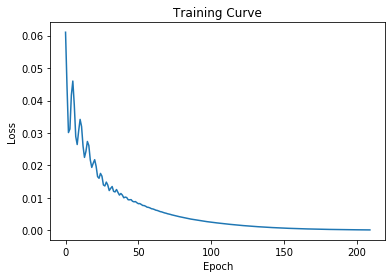

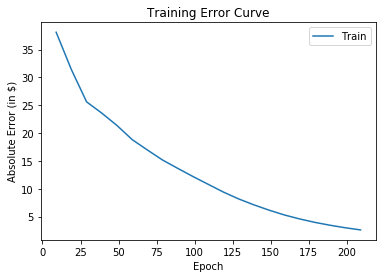

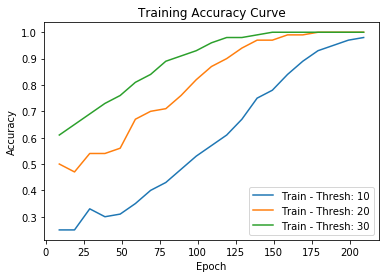

[EPOCH 211] loss: 0.000133  time: 0.118
[EPOCH 212] loss: 0.000129  time: 0.212
[EPOCH 213] loss: 0.000126  time: 0.223
[EPOCH 214] loss: 0.000123  time: 0.202
[EPOCH 215] loss: 0.000119  time: 0.215
[EPOCH 216] loss: 0.000116  time: 0.213
[EPOCH 217] loss: 0.000113  time: 0.220
[EPOCH 218] loss: 0.000110  time: 0.215
[EPOCH 219] loss: 0.000107  time: 0.215
[EPOCH 220] loss: 0.000105  time: 0.542


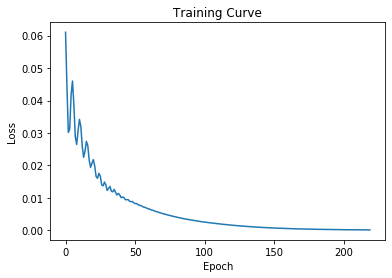

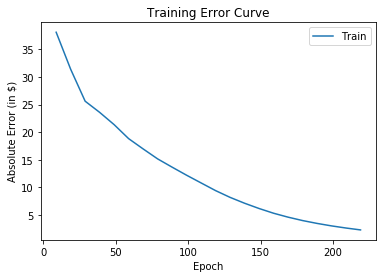

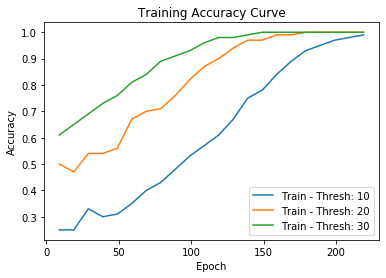

[EPOCH 221] loss: 0.000102  time: 0.118
[EPOCH 222] loss: 0.000099  time: 0.202
[EPOCH 223] loss: 0.000096  time: 0.221
[EPOCH 224] loss: 0.000094  time: 0.216
[EPOCH 225] loss: 0.000091  time: 0.218
[EPOCH 226] loss: 0.000089  time: 0.216
[EPOCH 227] loss: 0.000087  time: 0.220
[EPOCH 228] loss: 0.000085  time: 0.201
[EPOCH 229] loss: 0.000082  time: 0.214
[EPOCH 230] loss: 0.000080  time: 0.549


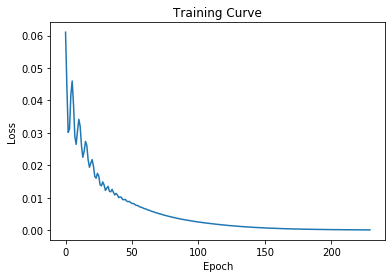

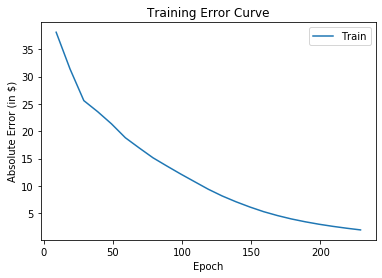

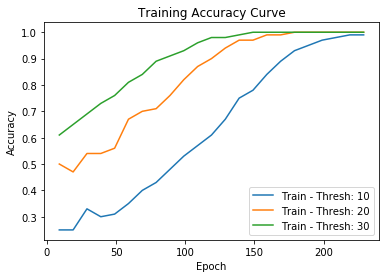

[EPOCH 231] loss: 0.000078  time: 0.113
[EPOCH 232] loss: 0.000076  time: 0.221
[EPOCH 233] loss: 0.000074  time: 0.213
[EPOCH 234] loss: 0.000072  time: 0.212
[EPOCH 235] loss: 0.000070  time: 0.210
[EPOCH 236] loss: 0.000069  time: 0.219
[EPOCH 237] loss: 0.000067  time: 0.241
[EPOCH 238] loss: 0.000065  time: 0.231
[EPOCH 239] loss: 0.000063  time: 0.243
[EPOCH 240] loss: 0.000062  time: 0.585


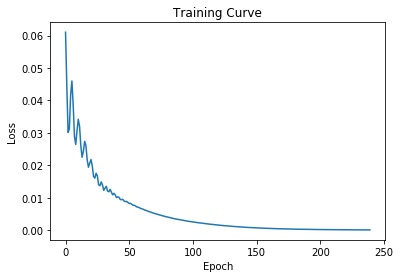

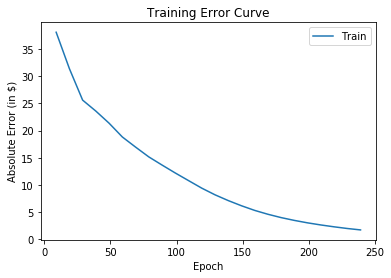

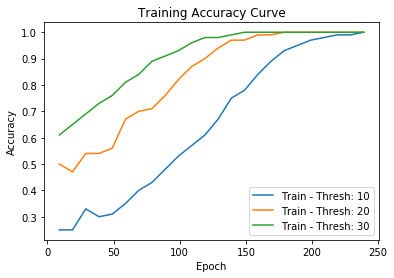

[EPOCH 241] loss: 0.000060  time: 0.153
[EPOCH 242] loss: 0.000059  time: 0.193
[EPOCH 243] loss: 0.000057  time: 0.206
[EPOCH 244] loss: 0.000056  time: 0.207
[EPOCH 245] loss: 0.000054  time: 0.211
[EPOCH 246] loss: 0.000053  time: 0.223
[EPOCH 247] loss: 0.000052  time: 0.210
[EPOCH 248] loss: 0.000050  time: 0.213
[EPOCH 249] loss: 0.000049  time: 0.219
[EPOCH 250] loss: 0.000048  time: 0.547


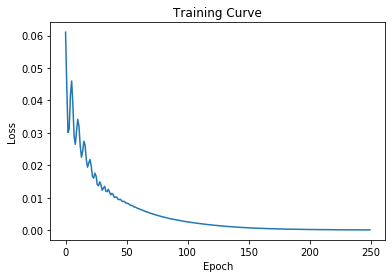

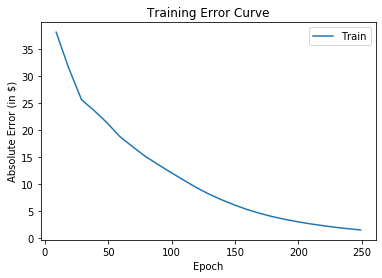

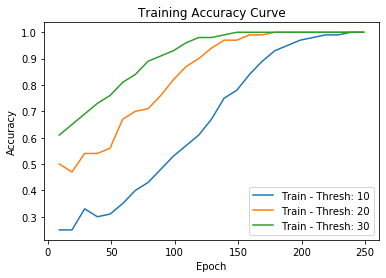

Training Completed...
[FINAL] loss: 0.000048  time: 80.004


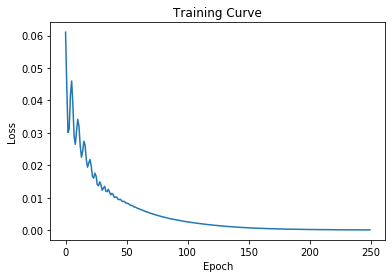

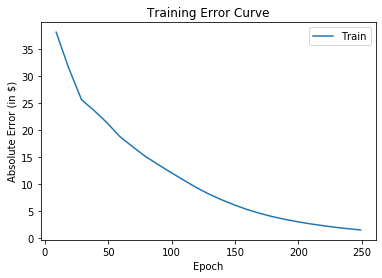

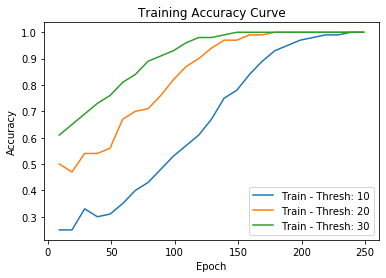

In [25]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Aditi/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

#train(net, train_loader, val_loader, [minimum, maximum], rootdir)

train(net, train_loader, val_loader, [min_price, max_price], rootdir, lr = 0.01, num_epoch = 250)

In [54]:
accum = 0
accum1 = 0
for i in range(100):
    error = net(train_ds[i]["sample"]).item() - train_ds[i]["label"].item()
    accum += error
    accum1 += abs(error)
    print(net(train_ds[i]["sample"]).item(), train_ds[i]["label"].item(), error)
print("Error:", accum/100)

print("Abs Error:", accum1/100*(bounds[1]-bounds[0]))

0.4214916527271271 0.21405750513076782 0.20743414759635925
0.5276427268981934 0.3258785903453827 0.20176413655281067
0.2150266170501709 0.1405750811100006 0.07445153594017029
0.23273341357707977 0.03194888308644295 0.20078453049063683
0.09710259735584259 0.23642171919345856 -0.13931912183761597
0.41814690828323364 0.36421725153923035 0.053929656744003296
0.31207364797592163 0.2044728398323059 0.10760080814361572
0.1313839703798294 0.2651757299900055 -0.1337917596101761
0.08688503503799438 0.01277955248951912 0.07410548254847527
0.05793289840221405 0.028753994032740593 0.029178904369473457
0.31027013063430786 0.36421725153923035 -0.053947120904922485
0.3767816424369812 0.2843450605869293 0.09243658185005188
0.2956864833831787 0.2747603952884674 0.020926088094711304
0.20870961248874664 0.2044728398323059 0.004236772656440735
0.28128132224082947 0.1405750811100006 0.14070624113082886
0.2540990710258484 0.23642171919345856 0.01767735183238983
0.12372308224439621 0.04472843557596207 0.07899

In [ ]:
for i, data in enumerate(train_loader):
    print(len(data["label"]))
    break

In [ ]:
train_ds[4]["label"].item()


In [16]:
a = [3, 6, 9]
a = [i/3 for i in a]

In [17]:
a

[1.0, 2.0, 3.0]

In [26]:
[[], []]

[[], []]

4